## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

reduce_lr_factor = [0.5 , 0.8]
reduce_lr_patient = [5 , 8]

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, reduce_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr =  ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 3s 68us/step - loss: 1.2767 - acc: 0.5567 - val_loss: 1.4781 - val_acc: 0.4826
Epoch 12/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.2500 - acc: 0.5661 - val_loss: 1.4738 - val_acc: 0.4812
Epoch 13/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.2254 - acc: 0.5760 - val_loss: 1.4735 - val_acc: 0.4837
Epoch 14/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.2007 - acc: 0.5852 - val_loss: 1.4568 - val_acc: 0.4897
Epoch 15/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.1752 - acc: 0.5937 - val_loss: 1.4538 - val_acc: 0.4891
Epoch 16/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.1529 - acc: 0.6039 - val_loss: 1.4501 - val_acc: 0.4933
Epoch 17/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.1303 - acc: 0.6115 - val_loss: 1.4470 - val_acc: 0.4959
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 93us/step - loss: 2.2048 - acc: 0.2650 - val_loss: 2.1254 - val_acc: 0.3004
Epoch 2/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.7464 - acc: 0.3873 - val_loss: 1.8175 - val_acc: 0.3688
Epoch 3/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.6196 - acc: 0.4325 - val_loss: 1.6793 - val_acc: 0.4120
Epoch 4/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.5448 - acc: 0.4589 - val_loss: 1.6226 - val_acc: 0.4288
Epoch 5/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.4902 - acc: 0.4787 - val_loss: 1.5894 - val_acc: 0.4399
Epoch 6/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.4436 - acc: 0.4936 - val_loss: 1.5666 - val_acc: 0.4479
Epoch 7/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.4042 - acc: 0.5091 - val_loss: 1.5500 - val_acc

50000/50000 [==============================] - 4s 74us/step - loss: 0.4403 - acc: 0.8687 - val_loss: 1.6926 - val_acc: 0.5056
Epoch 24/25
50000/50000 [==============================] - 4s 73us/step - loss: 0.4241 - acc: 0.8752 - val_loss: 1.7008 - val_acc: 0.5024

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 25/25
50000/50000 [==============================] - 4s 73us/step - loss: 0.3764 - acc: 0.8973 - val_loss: 1.6056 - val_acc: 0.5160
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048    

50000/50000 [==============================] - 4s 74us/step - loss: 1.1351 - acc: 0.6086 - val_loss: 1.5007 - val_acc: 0.4704
Epoch 10/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.1025 - acc: 0.6220 - val_loss: 1.4995 - val_acc: 0.4645
Epoch 11/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.0701 - acc: 0.6337 - val_loss: 1.4251 - val_acc: 0.4915
Epoch 12/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.0429 - acc: 0.6441 - val_loss: 1.4729 - val_acc: 0.4767
Epoch 13/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.0116 - acc: 0.6567 - val_loss: 1.4516 - val_acc: 0.4879
Epoch 14/25
50000/50000 [==============================] - 4s 74us/step - loss: 0.9885 - acc: 0.6658 - val_loss: 1.4379 - val_acc: 0.4909
Epoch 15/25
50000/50000 [==============================] - 4s 74us/step - loss: 0.9604 - acc: 0.6788 - val_loss: 1.4462 - val_acc: 0.4940
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.8119 - acc: 0.3716 - val_loss: 2.2779 - val_acc: 0.2880
Epoch 2/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.5422 - acc: 0.4569 - val_loss: 2.8293 - val_acc: 0.2148
Epoch 3/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.4363 - acc: 0.4927 - val_loss: 2.0337 - val_acc: 0.3120
Epoch 4/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.3565 - acc: 0.5212 - val_loss: 2.1325 - val_acc: 0.3160
Epoch 5/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.2943 - acc: 0.5426 - val_loss: 2.2584 - val_acc: 0.3057
Epoch 6/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.2393 - acc: 0.5617 - val_loss: 3.2289 - val_acc: 0.1729
Epoch 7/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.1917 - acc: 0.5786 - val_loss: 2.4851 - val_ac

50000/50000 [==============================] - 4s 72us/step - loss: 0.6384 - acc: 0.7997 - val_loss: 1.5872 - val_acc: 0.4880
Epoch 23/25
50000/50000 [==============================] - 4s 71us/step - loss: 0.6149 - acc: 0.8104 - val_loss: 1.5522 - val_acc: 0.4909
Epoch 24/25
50000/50000 [==============================] - 4s 72us/step - loss: 0.5948 - acc: 0.8169 - val_loss: 1.5324 - val_acc: 0.4936
Epoch 25/25
50000/50000 [==============================] - 4s 73us/step - loss: 0.5764 - acc: 0.8238 - val_loss: 1.6107 - val_acc: 0.4758
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch

Epoch 8/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2955 - acc: 0.5510 - val_loss: 1.5416 - val_acc: 0.4575
Epoch 9/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2601 - acc: 0.5632 - val_loss: 1.5345 - val_acc: 0.4583
Epoch 10/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.2229 - acc: 0.5807 - val_loss: 1.5237 - val_acc: 0.4695
Epoch 11/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.1927 - acc: 0.5909 - val_loss: 1.5316 - val_acc: 0.4672
Epoch 12/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.1603 - acc: 0.6029 - val_loss: 1.5090 - val_acc: 0.4721
Epoch 13/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.1310 - acc: 0.6135 - val_loss: 1.5261 - val_acc: 0.4712
Epoch 14/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.1033 - acc: 0.6249 - val_loss: 1.5931 - val_acc: 0.4453
Epoch 15/25
50000/50000 [===========

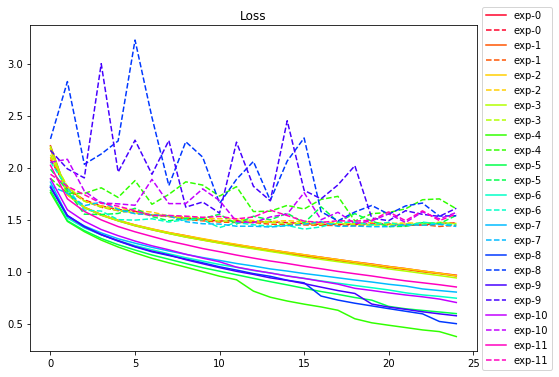

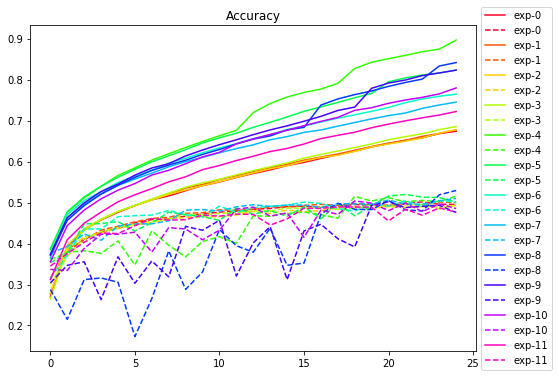

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()